# Assignment 2

A NN 
- with one hidden layer (5 nodes)
- NN activation function tanh
- bias can be ignored
- input layer with 2 nodes
- output layer with 2 nodes
- softmax with cross entropy training

Let's first create a plotting function

In [10]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import matplotlib.mlab as mlab
import time
%matplotlib inline


def plot_it(x_min=-2, x_max=2, y_min=-2, y_max=2, npts=8000, dataset=[], nn_callback=None):
    xi = np.linspace(x_min, x_max, 100)
    yi = np.linspace(y_min, y_max, 100)


    x = np.random.uniform(x_min, x_max, npts)
    y = np.random.uniform(y_min, y_max, npts)
    z=[]
    for i in range(npts):
        #forward_pass(nn, [x[i], y[i]])[0]
        z.append(nn_callback(nn, [x[i], y[i]])[0] )
    zi = mlab.griddata(x, y, z, xi, yi, interp='linear')
    plt.contour(xi, yi, zi, 0, linewidths=0.5, colors='k')
    plt.contourf(xi, yi, zi, 15,
                 norm=plt.Normalize(vmax=abs(zi).max(), vmin=-abs(zi).max()))
    plt.colorbar()  # draw colorbar

    tr_points_x = [a[0] for a, b in dataset if b[0] == 1]
    tr_points_y = [a[1] for a, b in dataset  if b[0] == 1]
    plt.plot(tr_points_x, tr_points_y, 'yo', ms=4)


    tr_points_x = [a[0] for a, b in dataset if b[0] == 0]
    tr_points_y = [a[1] for a, b in dataset  if b[0] == 0]
    plt.plot(tr_points_x, tr_points_y, 'go', ms=4)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    

Now, the actual NN code

In [6]:
import numpy as np
import math

def actF(x):
    act = math.tanh(x)
    return [act, 1-act*act]

class NodeLayer:

    def __init__(self, nrNodes, outputLayer=False):
        self.nrNodes = nrNodes
        self.outputLayer = outputLayer
        self.bottom_values = np.zeros([nrNodes])
        self.top_values = np.zeros([nrNodes])
        self.derivative_of_values = np.zeros([nrNodes])

        self.top_error_grad = np.zeros([nrNodes])
        self.bottom_error_grad = np.zeros([nrNodes])
        
    def forward_pass(self):
        if self.outputLayer == False:
            for nodeNo in range(self.nrNodes):
                self.top_values[nodeNo], self.derivative_of_values[nodeNo] = actF(self.bottom_values[nodeNo])
    
    def backward_pass(self):
        for nodeNo in range(self.nrNodes):
            self.bottom_error_grad[nodeNo] = self.derivative_of_values[nodeNo] * self.top_error_grad[nodeNo]
            
    def softmax_normalization(self):
        self.top_values = np.array([math.exp(v) for v in self.bottom_values])
        softmax_sum = np.sum(self.top_values)
        self.top_values /= softmax_sum
        
    def update_weights(self, eta):
        pass
    
    def update_weights_regularized(self, eta, reg="", alpha=0):
        pass
        
class WeightConnection:

    def __init__(self, nrNodesIn, nrNodesOut):
        self.nrNodesIn=nrNodesIn
        self.nrNodesOut=nrNodesOut
        self.weights = np.random.uniform(-1,1, [nrNodesOut, nrNodesIn])
        
        self.bottom_values = np.zeros([nrNodesIn])
        self.top_values = np.zeros([nrNodesOut])
        self.top_error_grad = np.zeros([nrNodesOut])
        self.bottom_error_grad = np.zeros([nrNodesIn])
        self.delta = np.zeros(self.weights.shape)
        
    def forward_pass(self):
        self.bottom_values = np.concatenate([self.bottom_values])
        self.top_values = self.weights.dot(self.bottom_values)


    def backward_pass(self):
        self.bottom_error_grad = self.weights.transpose().dot(self.top_error_grad)
        
    def add_weight_gradient(self):
        self.delta += np.outer(self.top_error_grad, self.bottom_values)
        
    def update_weights(self, eta):
        self.weights = self.weights - eta * self.delta
        self.delta = np.zeros(self.weights.shape) 

    def update_weights_regularized(self, eta, reg="", alpha=0):
        if reg == "L2":
            self.weights = (1-eta*alpha)*self.weights - eta * self.delta
        if reg == "L1":
            a = self.delta/np.abs(self.delta)
            self.weights = self.weights - eta * (self.delta + alpha*a)
        self.delta = np.zeros(self.weights.shape)
        

def forward_pass(nn, x):
    nn[0].top_values = x

    for layerNo, layer in enumerate(nn[1:]):
        layer.bottom_values = nn[layerNo].top_values
        layer.forward_pass()

    nn[-1].softmax_normalization()
    
    return nn[-1].top_values

def backward_pass(nn, target):
    nn[-1].bottom_error_grad = nn[-1].top_values - target
    for layerNo in range(len(nn)-2, -1, -1):
        nn[layerNo].top_error_grad = nn[layerNo+1].bottom_error_grad
        nn[layerNo].backward_pass()
        
def forward_backward_pass(nn, x, y):
    forward_pass(nn, x)
    backward_pass(nn, y)

    for layerNo in range(1,len(nn), 2): #only the weight connection layers
        nn[layerNo].add_weight_gradient()
        
def update_weights(nn, eta):

    for layer in nn: #only the weight connection layers
        layer.update_weights(eta)
        
def training(nn, tr, steps, eta):
    for _ in range(steps):
        for x,y in tr:
            forward_backward_pass(nn, x, y)
            update_weights(nn, eta)
            


We define our neural network like this

In [ ]:
nn = []
nn.append(NodeLayer(2))     # input nodes
nn.append(WeightConnection(2, 5))
nn.append(NodeLayer(5))
nn.append(WeightConnection(5, 2))
nn.append(NodeLayer(2, outputLayer=True))

Now, we can load the homework data

In [ ]:
all_data = np.loadtxt("Assignment1Data.txt")
x = all_data[:,0:2]
onehot = np.zeros(x.shape)
onehot[np.arange(x.shape[0]), all_data[:,2].astype(np.int)] = 1

homework_dataset = zip(x, onehot)

And start the training (and a timer to see how long it takes)

We go with 100 iterations and a learning rate of 0.01

In [14]:
start = time.clock()
training(nn, homework_dataset, steps=100, eta=0.01)
print('training in seconds: %f' % (time.clock() - start))

training in seconds: 14.801463


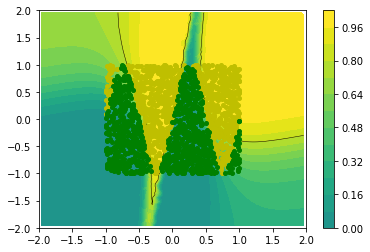

In [15]:
plot_it(dataset=homework_dataset, nn_callback=forward_pass)